In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import numpy as np
import tqdm

In [2]:
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)
                        
        R = 6373.0
                        
        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def plot_one_min_data(stn_id, v, event_time, ax, ls="-", color="tab:blue", marker=None, pad=2):
    
    for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+stn_id+"_*.txt"):
        df = pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)
        if np.min(np.abs(df.index - event_time)).seconds < 3600:
                if (stn_id == "090035") & (event_time.year==2020) & (event_time.month==1) & (event_time.day==31):
                    time = df.sort_values("wg").index[-2]
                else:
                    time = df.index[np.argmax(df.wg)]
                times = [time + dt.timedelta(seconds=-2*60*60), time + dt.timedelta(seconds=2*60*60)]
                df = df.loc[slice(times[0], times[1])]
                df = df.set_index(pd.DatetimeIndex(df.index))

                if v == "wg":
                    ax.set_ylim([0,40])
                    lab="Wind gust (m/s)"
                elif v == "wd":
                    ax.set_ylim([0,360])
                    lab="Direction from North (degrees)"
                elif v == "mslp":
                    ax.set_ylim([998,1020])   
                    lab="Mean sea-level pressure (hPa)"
                elif v == "dp":
                    ax.set_ylim([5,45])                     
                    lab="Dewpoint temperature (Celsius)"
                elif v == "t":
                    ax.set_ylim([5,45]) 
                    lab="Air temperature (Celsius)"                    
                elif v in ["p"]:
                    ax.set_ylim([0,40])                 
                    lab="Precipitation (mm)"
                if v == "p":
                    df[v] = pd.to_numeric(df[v], errors="coerce").cumsum()                   
                else:
                    df[v] = pd.to_numeric(df[v], errors="coerce").interpolate()                         
                line = ax.plot(df.index.to_pydatetime(), df[v].values, ls=ls, color=color, marker=marker, label=lab)
                ax.tick_params(axis='y', colors=color, pad=pad)
                ax.tick_params(axis='x', rotation=25)    
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                ax.axvline(time, color="k", ls="--", lw=1)
                
                return line
        else:
                pass
   
def plot_driver(state, stn_id, t, rows, cols, num, title, legend=False, left_ticks=False, right_ticks=False):
    lightning1 = load_lightning((t+dt.timedelta(days=-1)).strftime("%Y%m%d"), stn_id, state)
    lightning2 = load_lightning((t+dt.timedelta(days=0)).strftime("%Y%m%d"), stn_id, state)
    lightning3 = load_lightning((t+dt.timedelta(days=1)).strftime("%Y%m%d"), stn_id, state) 
    lightning = pd.concat([lightning1, lightning2, lightning3], axis=0)
    lightning = lightning.loc[(lightning.index>=(t + dt.timedelta(seconds=-2*60*60))) & (lightning.index <= t + dt.timedelta(seconds=2*60*60)),"latlon"]    
    ax1=plt.subplot(rows,cols,num)
    ax2=ax1.twinx()
    ax3=ax1.twinx()    
    line1=plot_one_min_data(stn_id, "wg", t, ax1,color="tab:red")
    # line2=plot_one_min_data(stn_id, "wd", t, ax2, color="tab:red", ls=":")
    line2=plot_one_min_data(stn_id, "p", t, ax2, color="tab:blue", ls="--", pad=15)    
    line3=ax3.plot(lightning, color="tab:purple", lw=0.5, label="Lightning strokes in 75 km radius (1 min.)")
    ax3.tick_params(axis='y', colors="tab:purple", pad=5)
    ax3.set_ylim([-1,30])
    ax1.grid()
    ax1.set_title(title, loc="left")
    if legend:
        plt.legend((line1[0], line2[0], line3[0]), (line1[0].get_label(), line2[0].get_label(),line3[0].get_label()),
                   loc=3, bbox_to_anchor=(-0.05,-0.8), ncol=3)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    if legend:
        plt.legend((line1[0], line2[0], line3[0]), (line1[0].get_label(), line2[0].get_label(), line3[0].get_label()),
               loc=3, bbox_to_anchor=(0,-0.8), ncol=3,fontsize="large")
        
    if not left_ticks:
        ax1.set_yticklabels("")
    if not right_ticks:
        ax2.set_yticklabels("")        
        ax3.set_yticklabels("")                
    
def load_lightning(date, stn_no, state):

    try:
        lightning = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/ad_data/lightning_raw/A"+date+".loc",header=None,
                               names=["date","time","lat","lon","1","2"])
    except:
        lightning = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/ad_data/lightning_raw/AE"+date+".loc",header=None,
                               names=["date","time","lat","lon","1","2","3","4","5"])
    names = ["id", "stn_no", "district", "stn_name", "site_open", "site_close", "lat", "lon", "latlon_method", "state",\
                    "hgt_asl", "hgt_asl_baro", "wmo_idx", "y1", "y2", "comp%", "Y%", "N%", "W%", "S%", "I%", "#"]
    stn_df = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+state+"_one_min_gust/HD01D_StnDet_*.txt")[0],\
            names=names, header=0)
    lightning["l_dist"] = latlon_dist(stn_df[stn_df.stn_no==int(stn_no)].lat.values[0], stn_df[stn_df.stn_no==int(stn_no)].lon.values[0],
        lightning["lat"], lightning["lon"])
    lightning["latlon"] = lightning["lat"].astype("str") + " " + lightning["lon"].astype("str")
    lightning["latlon"] = lightning.latlon.where(lightning.l_dist <= 75, np.nan)

    lightning["datetime"] = pd.DatetimeIndex(lightning["date"] + " " + lightning["time"])
    lightning = lightning.set_index(lightning["datetime"])    
    return lightning[["lat","lon","l_dist","latlon"]].resample("1min").nunique()    

100%|██████████| 9/9 [02:04<00:00, 13.85s/it]


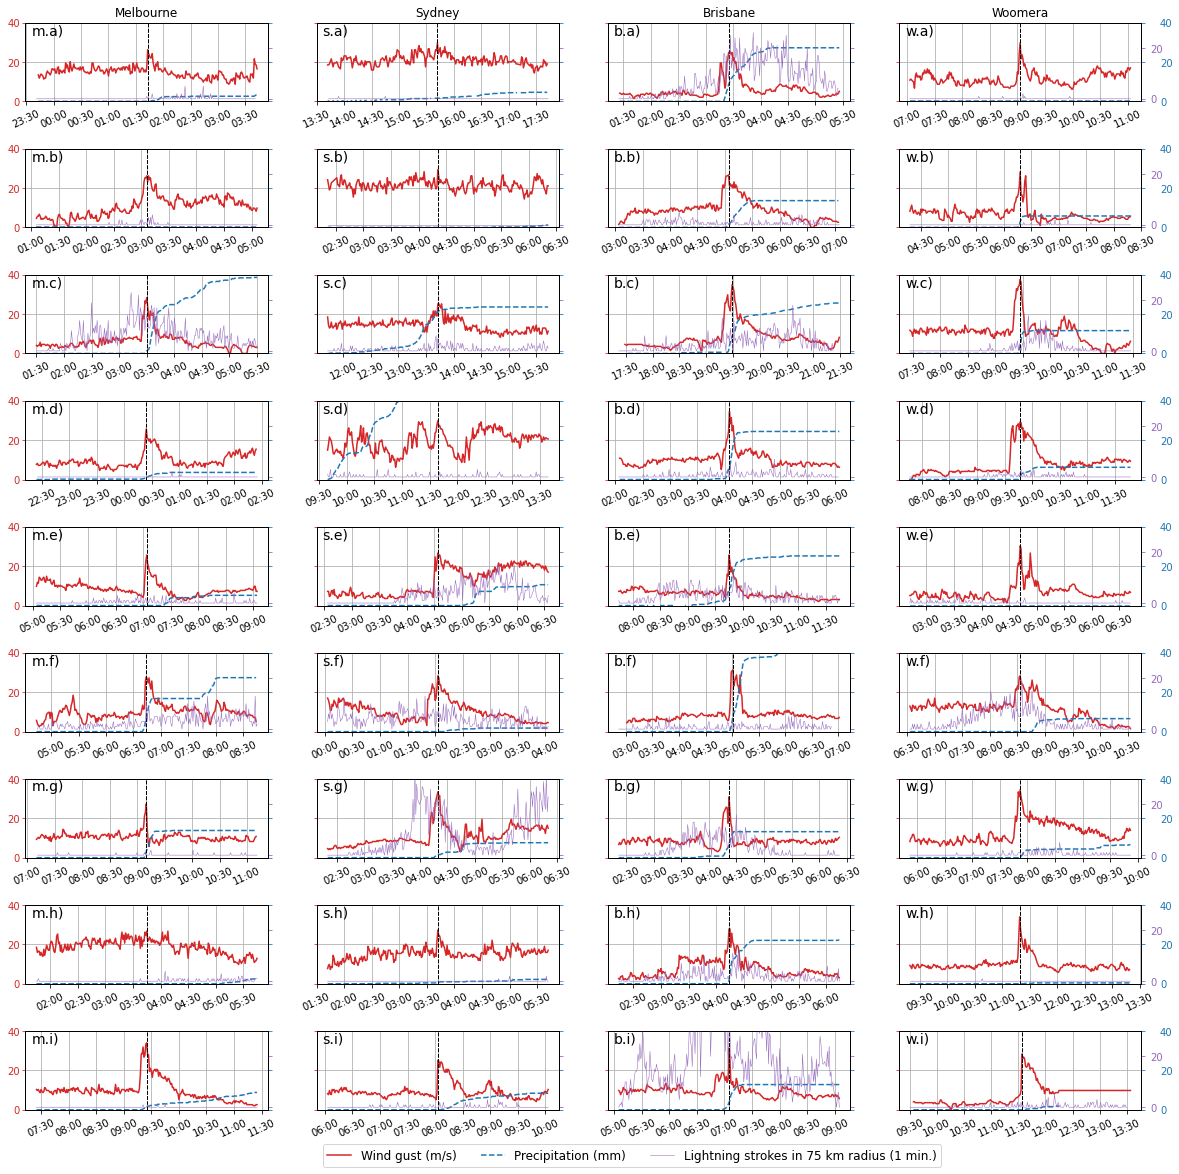

In [3]:
fig = plt.figure(figsize=[20,20])
letters = ["a","b","c","d","e","f","g","h","i"]
rows = 9; cols = 4

details_list = [[\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2006,9,24,1,41)], "rid":"2", "title":"a) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2009,11,20,3,6)], "rid":"2", "title":"b) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,3,6,3,30)], "rid":"2", "title":"c) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,6,17,0,25)], "rid":"2", "title":"d) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,11,18,7,4)], "rid":"2", "title":"e) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,12,25,6,45)], "rid":"2", "title":"f) Melbourne:  UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2012,2,26,9,11)], "rid":"2", "title":"g) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2013,3,21,3,45)], "rid":"2", "title":"h) Melbourne: UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2015,2,28,9,25)], "rid":"2", "title":"i) Melbourne:  UTC"},\
       ], [\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2010,8,2,15,43)], "rid":"71", "title":"a) Sydney:  UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2012,8,10,4,21)], "rid":"71", "title":"b) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2013,2,23,13,43)], "rid":"71", "title":"c) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2014,10,14,11,39)], "rid":"71", "title":"d) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,3,1,4,34)], "rid":"71", "title":"e) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,12,16,2,3)], "rid":"71", "title":"f) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,1,14,4,20)], "rid":"71", "title":"g) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,6,4,3,42)], "rid":"71", "title":"h) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2017,4,9,8,3)], "rid":"71", "title":"i) Sydney: UTC"},\
       ], [\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2010,12,16,3,25)], "rid":"66", "title":"a) Amberley: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2011,1,18,5,5)], "rid":"66", "title":"b) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2011,10,7,19,22)], "rid":"50", "title":"c) Oakey: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2013,10,18,4,4)], "rid":"50", "title":"d) Oakey: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2013,11,23,9,45)], "rid":"66", "title":"e) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2014,1,23,4,52)], "rid":"50", "title":"f) Oakey UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2016,1,29,4,22)], "rid":"50", "title":"g) Oakey UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2016,12,18,4,14)], "rid":"66", "title":"h) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2018,2,13,7,5)], "rid":"50", "title":"i) Oakey: UTC"},\
       ], [\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2007,10,27,9,3)], "rid":"27", "title":"a) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2008,12,9,6,18)], "rid":"27", "title":"b) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2010,12,7,9,27)], "rid":"27", "title":"c) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2011,11,8,9,47)], "rid":"27", "title":"d) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,1,29,4,42)], "rid":"27", "title":"e) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,11,30,8,33)], "rid":"27", "title":"f) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2014,10,31,7,52)], "rid":"27", "title":"g) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2015,12,7,11,20)], "rid":"27", "title":"h) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2017,12,18,11,30)], "rid":"27", "title":"i) "},\
       ]  ]
           
details = details_list[0] #MELB EVENTS
cnt = 1
letters_cnt=0
for d in tqdm.tqdm(details):
    t = d["time"][0]; state="vic"; stn_id = "086282"; plot_driver(state, stn_id, t, rows, cols, cnt, "", left_ticks=True)
    if cnt==1:
        plt.title("Melbourne") 
    plt.text(0.025,0.85,"m."+letters[letters_cnt]+")",transform = plt.gca().transAxes,size=14)    
    cnt = cnt + 4
    letters_cnt=letters_cnt+1

details = details_list[1] #SYD EVENTS
cnt = 2
letters_cnt=0
for d in tqdm.tqdm(details):
    if cnt == 34:
        t = d["time"][0]; state="nsw"; stn_id = "066037"; plot_driver(state, stn_id, t, rows, cols, cnt, "",legend=True)
    else:
        t = d["time"][0]; state="nsw"; stn_id = "066037"; plot_driver(state, stn_id, t, rows, cols, cnt, "")
    if cnt==2:
        plt.title("Sydney")
    plt.text(0.025,0.85,"s."+letters[letters_cnt]+")",transform = plt.gca().transAxes,size=14)    
    cnt = cnt + 4    
    letters_cnt=letters_cnt+1
    
details = details_list[2] #BRIS EVENTS
cnt = 3
letters_cnt=0
for d in tqdm.tqdm(details):
    if "Amberley" in d["title"]:
        t = d["time"][0]; state="qld"; stn_id = "040004"; plot_driver(state, stn_id, t, rows, cols, cnt, "")
    else:
        t = d["time"][0]; state="qld"; stn_id = "041359"; plot_driver(state, stn_id, t, rows, cols, cnt, "")
    if cnt==3:
        plt.title("Brisbane")
    plt.text(0.025,0.85,"b."+letters[letters_cnt]+")",transform = plt.gca().transAxes,size=14)    
    cnt = cnt + 4
    letters_cnt=letters_cnt+1    
    
details = details_list[3] #WOOMERA EVENTS
cnt = 4
letters_cnt=0
for d in tqdm.tqdm(details):
    t = d["time"][0]; state="sa"; stn_id = "016001"; plot_driver(state, stn_id, t, rows, cols, cnt, "", right_ticks=True)
    if cnt==4:
        plt.title("Woomera")
    plt.text(0.025,0.85,"w."+letters[letters_cnt]+")",transform = plt.gca().transAxes,size=14)    
    cnt = cnt + 4
    letters_cnt=letters_cnt+1
    
plt.subplots_adjust(hspace=0.6)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/one_min_obs_2.jpeg", quality=100, bbox_inches="tight")

In [4]:
#GET PRECIP STATS

df = pd.DataFrame()
for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+"086282"+"_*.txt"):
        df = pd.concat([df,pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)], axis=0)
print("Melboune")
for detail in details_list[0]:
    print(pd.to_numeric(df.drop_duplicates("dt_lt").loc[slice(detail["time"][0], detail["time"][0] + dt.timedelta(minutes=60)),:].p, errors="coerce").sum())
print("\n")

df = pd.DataFrame()
for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+"066037"+"_*.txt"):
        df = pd.concat([df,pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)], axis=0)
print("Sydney")
for detail in details_list[1]:
    print(pd.to_numeric(df.drop_duplicates("dt_lt").loc[slice(detail["time"][0], detail["time"][0] + dt.timedelta(minutes=60)),:].p, errors="coerce").sum())
print("\n")

df = pd.DataFrame()
for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+"040004"+"_*.txt"):
        df = pd.concat([df,pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)], axis=0)
print("Amberley")
for detail in details_list[2]:
    print(pd.to_numeric(df.drop_duplicates("dt_lt").loc[slice(detail["time"][0], detail["time"][0] + dt.timedelta(minutes=60)),:].p, errors="coerce").sum())
print("\n")

df = pd.DataFrame()
for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+"041359"+"_*.txt"):
        df = pd.concat([df,pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)], axis=0)
print("Oakey")
for detail in details_list[2]:
    print(pd.to_numeric(df.drop_duplicates("dt_lt").loc[slice(detail["time"][0], detail["time"][0] + dt.timedelta(minutes=60)),:].p, errors="coerce").sum())
print("\n")

df = pd.DataFrame()
for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/one_min_case_data_2/HD01D_Data_"+"016001"+"_*.txt"):
        df = pd.concat([df,pd.read_csv(f,
                   names=["hd","stn_no","dt_lt","Time (UTC)","p","p_q","p_p","t","t1","dp","dp_q",\
                          "rh","rh_q","ws","ws_q","min_ws","min_ws_q","wd","wd_q","std_wd","std_wd_q",\
                          "wg","wg_q","mslp","mslp_q","pres","pres_q","qnh","qnh_q","#"], header=0, index_col="Time (UTC)", parse_dates=True)], axis=0)
print("Woomera")
for detail in details_list[3]:
    print(pd.to_numeric(df.drop_duplicates("dt_lt").loc[slice(detail["time"][0], detail["time"][0] + dt.timedelta(minutes=60)),:].p, errors="coerce").sum())
print("\n")

Melboune
2.6
0.0
32.2
2.6000000000000005
4.800000000000001
11.2
10.600000000000001
0.0
3.4000000000000004


Sydney
2.4000000000000004
0.2
2.6
22.0
7.4
1.8000000000000003
6.0
0.6000000000000001
6.800000000000001


Amberley
20.6
12.2
0.2
0.0
18.0
11.0
5.6
22.0
0.0


Oakey
0.0
0.0
20.599999999999998
20.4
0.2
40.000000000000014
8.0
0.0
10.2


Woomera
0.0
5.0
9.8
5.2
0.0
6.6000000000000005
4.4
0.4
1.8000000000000003




In [5]:
#GET LIGHTNING STATS

print("Melbourne")
for details in details_list[0]:
    temp = load_lightning(details["time"][0].strftime("%Y%m%d"), "086282", "vic")
    print(temp.loc[slice(details["time"][0] + dt.timedelta(minutes=-30), details["time"][0] + dt.timedelta(minutes=+30))].latlon.sum())
print("\n")

print("Sydney")
for details in details_list[1]:
    temp = load_lightning(details["time"][0].strftime("%Y%m%d"), "066037", "nsw")
    print(temp.loc[slice(details["time"][0] + dt.timedelta(minutes=-30), details["time"][0] + dt.timedelta(minutes=+30))].latlon.sum())
print("\n")

print("Brisbane")
for details in details_list[2]:
    if "Amberley" in details["title"]:
        temp = load_lightning(details["time"][0].strftime("%Y%m%d"), "040004", "qld")
    else:
        temp = load_lightning(details["time"][0].strftime("%Y%m%d"), "041359", "qld")
    print(temp.loc[slice(details["time"][0] + dt.timedelta(minutes=-30), details["time"][0] + dt.timedelta(minutes=+30))].latlon.sum())
print("\n")

print("Woomera")
for details in details_list[3]:
    temp = load_lightning(details["time"][0].strftime("%Y%m%d"), "016001", "sa")
    print(temp.loc[slice(details["time"][0] + dt.timedelta(minutes=-30), details["time"][0] + dt.timedelta(minutes=+30))].latlon.sum())
print("\n")

Melbourne
7
28
662
2
45
198
6
10
4


Sydney
0
0
81
17
274
317
888
0
11


Brisbane
712
31
238
73
261
42
420
209
1722


Woomera
4
5
180
39
6
469
36
0
21


